In [1]:
import argparse
parser = argparse.ArgumentParser(prog = 'Run Model')
parser.add_argument('--WalkerID', type=int, choices=range(10000), default=0)
parser.add_argument('--uv_filename', type=str, default='uv_final.npy')
parser.add_argument('--W_filepath', type=str, default='')
parser.add_argument('--saving_location', type=str, default='')
parser.add_argument('--averages_fstring', type=str, default='averages_{}_float32.npy')
parser.add_argument('--BoxesPath', type=str, default="/amphora/bradley.greig/21CMMC_wTs_LC_RSDs_Nicolas/Programs/LightConeBoxes")
parser.add_argument('--ParametersPath', type=str, default="/amphora/bradley.greig/21CMMC_wTs_LC_RSDs_Nicolas/Programs/GridPositions")
parser.add_argument('--depth_mhz', type=int, default = 0) # if depth==0 calculate it from cube, else fix it to given value
# parser.add_argument('--uv_treshold', type=int, default = 1) # taking in account only baselines which were visited uv_treshold amount of times 
parser.add_argument('--SKA_observation_time', type=int, default = 1000)
inputs = parser.parse_args("--WalkerID 20 --uv_filename /scratch/d.prelogovic/data/uv.npy --W_filepath /scratch/d.prelogovic/data/ --saving_location /scratch/d.prelogovic/pics/ --averages_fstring /scratch/d.prelogovic/data/averages/averages_{}_float32.npy --BoxesPath /scratch/d.prelogovic/data/original_database/".split(" "))


In [4]:
import numpy as np
import cupy as cp
import sys
import os
from src.py21cnn.database import DatabaseUtils
from src.py21cnn.formatting import Filters
import json

import matplotlib.pyplot as plt
import matplotlib
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [5]:
Redshifts = ['006.00060', '006.75589', '007.63960', '008.68274', '009.92624', '011.42503', \
            '013.25424', '015.51874', '018.36856', '022.02434', '026.82138', '033.28927', '034.50984']
Parameters = ["ZETA", "TVIR_MIN", "L_X", "NU_X_THRESH"]
database = DatabaseUtils.Database(Parameters, Redshifts, inputs.BoxesPath, inputs.ParametersPath)
deltaTmin = -250
deltaTmax = 50
Zmax = 30

print("loading lightcone")
Box = database.CombineBoxes(inputs.WalkerID)
print("removing large Z")
Box = Filters.RemoveLargeZ(Box, database, Z=Zmax)
print("removing NaNs")
np.nan_to_num(Box, copy=False, nan=deltaTmin, posinf=deltaTmax, neginf=deltaTmin)
print("move box to GPU")
Box = cp.asarray(Box)
print("clipping large values")
cp.clip(Box, deltaTmin, deltaTmax, out=Box)

BoxAverage = np.load(inputs.averages_fstring.format(inputs.WalkerID))
print("removing large Z for average")
BoxAverage = Filters.RemoveLargeZ(BoxAverage, database, Z=Zmax)
BoxAverage = cp.asarray(BoxAverage)

Box -= BoxAverage
Box = Box.astype(np.float32)

uv = np.load(inputs.uv_filename).astype(np.float32)
uv_bool = (uv < 1)

import tools21cm as t2c
N_ant = 512 #or 513?

t2c.const.set_hubble_h(0.678)
t2c.const.set_omega_matter(0.308)
t2c.const.set_omega_baryon(0.048425)
t2c.const.set_omega_lambda(0.692)
t2c.const.set_ns(0.968)
t2c.const.set_sigma_8(0.815)

d0 = t2c.cosmology.z_to_cdist(float(Redshifts[0]))
cdist = np.array(range(Box.shape[-1] + 1))*1.5 + d0
redshifts = t2c.cosmology.cdist_to_z(cdist)
redshifts_mean = (redshifts[:-1] + redshifts[1:]) / 2

loading lightcone
removing large Z
removing NaNs
move box to GPU
clipping large values
removing large Z for average


In [6]:
def noise(depth_mhz, seed_index):
    finalBox = []
    for i in range(Box.shape[-1]):
        if depth_mhz == 0:
            depth_mhz = t2c.cosmology.z_to_nu(redshifts[i]) - t2c.cosmology.z_to_nu(redshifts[i+1])
        noise = t2c.noise_model.noise_map(ncells=200,
                                          z=redshifts_mean[i],
                                          depth_mhz=depth_mhz,
                                          obs_time=inputs.SKA_observation_time,
                                          boxsize=300, 
                                          uv_map=uv[..., i],
                                          N_ant=N_ant,
                                          seed = 1000000*i + 100*inputs.WalkerID + seed_index, #last index is noise number index
                                          ) # I've corrected the function so it returns noise in uv, not in real space
        noise = t2c.telescope_functions.jansky_2_kelvin(noise, redshifts_mean[i])
        finalBox.append(noise)
    finalBox = np.moveaxis(np.array(finalBox), 0, -1)
#     finalBox[uv_bool] = 0
    return finalBox

Noise = noise(inputs.depth_mhz, seed_index = 0).astype(np.complex64)
#move everything to GPU
Noise = cp.asarray(Noise)
uv = cp.asarray(uv)
uv_bool = cp.asarray(uv_bool)

In [13]:
%matplotlib inline
def plotting(box, box_cleaned, box_n_noise, filename, suptitle, save = False):
    box = box.get()
    box_cleaned = box_cleaned.get()
    box_n_noise = box_n_noise.get()
    fig, ax =plt.subplots(3, 1, figsize=(25, 3*3))
    im = ax[0].imshow(box[0], vmin = -1e2, vmax = 1e2)
    ax[0].set_xticks(np.array(range(9)) * 250)
    ax[0].set_xticklabels([ f"{i:.1f}" for i in t2c.cosmology.cdist_to_z(np.array(range(9)) * 250 * 1.5 + d0)])
    ax[0].set_yticks([])
    plt.colorbar(im, ax = ax[0], fraction=0.005, pad=0.005)
    ax[0].set_title("signal", fontsize=16)

    im = ax[1].imshow(box_n_noise[0], vmin = -1e2, vmax = 1e2)
    ax[1].set_xticks(np.array(range(9)) * 250)
    ax[1].set_xticklabels([ f"{i:.1f}" for i in t2c.cosmology.cdist_to_z(np.array(range(9)) * 250 * 1.5 + d0)])
    ax[1].set_yticks([])
    plt.colorbar(im, ax = ax[1], fraction=0.005, pad=0.005)
    ax[1].set_title("signal + noise", fontsize=16)

    im = ax[2].imshow(box_cleaned[0], vmin = -1e2, vmax = 1e2)
    ax[2].set_xticks(np.array(range(9)) * 250)
    ax[2].set_xticklabels([ f"{i:.1f}" for i in t2c.cosmology.cdist_to_z(np.array(range(9)) * 250 * 1.5 + d0)])
    ax[2].set_yticks([])
    plt.colorbar(im, ax = ax[2], fraction=0.005, pad=0.005)
    ax[2].set_title("signal + noise + wedge removal", fontsize=16)
    plt.suptitle(suptitle, fontsize=20)
    if save:
        plt.savefig(filename)
    plt.show()
def plot_box(box, label_distance = 250):
    fig, ax =plt.subplots(1, 1, figsize=(25, 3))
    im = ax.imshow(box[0])
    ax.set_xticks(np.array(range(9)) * label_distance)
    ax.set_xticklabels([ f"{i:.1f}" for i in t2c.cosmology.cdist_to_z(np.array(range(9)) * 250 * 1.5 + d0)])
    ax.set_yticks([])
    plt.colorbar(im, ax = ax, fraction=0.005, pad=0.005)
    plt.show()

In [8]:
from scipy.integrate import quadrature

def one_over_E(z):
    return 1 / np.sqrt(t2c.const.Omega0*(1.+z)**3+t2c.const.lam)
def multiplicative_factor(z):
    return 1 / one_over_E(z) / (1+z) * quadrature(one_over_E, 0, z)[0]

print("calculating muliplicative factors")
multiplicative_fact = cp.array([multiplicative_factor(z) for z in redshifts_mean])
multiplicative_fact = multiplicative_fact.astype(np.float32)

calculating muliplicative factors


In [289]:
def manual_slicing(Box, chunk_length = 200, blackman = False, wedge_correction = 1):
    slices = Box.shape[-1] // chunk_length
    Box_final = cp.empty((Box.shape[0], Box.shape[1], slices * chunk_length), dtype = np.float32)
#     Noise = noise(inputs.depth_mhz, seed_index = 0).astype(np.float32)
    Box_uv = cp.fft.fft2(Box, axes=(0, 1)) + Noise
    Box_uv[uv_bool] = 0
    
    k = cp.fft.fftfreq(200, d=1.5)
    k_parallel = cp.fft.fftfreq(chunk_length, d=1.5)
    k_cube = cp.meshgrid(k, k, k_parallel)
    W = k_cube[2] / cp.sqrt(k_cube[0]**2 + k_cube[1]**2)
    
    BM = cp.blackman(chunk_length)[cp.newaxis, cp.newaxis, :]

#     plt.imshow(cp.logical_or(cp.fft.fftshift(W) / multiplicative_fact[0] > 1, cp.fft.fftshift(W) / multiplicative_fact[0] < -1).get()[100, ...])
#     plt.colorbar()
#     plt.show()
    for i in range(slices):
        t_box = Box_uv[..., i * chunk_length: (i + 1) * chunk_length]
        if blackman == True:
            t_box = t_box * BM
        W_index = (i+1) * chunk_length
        t_W = W / (multiplicative_fact[W_index] / wedge_correction)
#         print(W_index)
#         print(multiplicative_fact[W_index])

        w = cp.logical_or(t_W < -1., t_W > 1.)
#         plt.imshow(cp.fft.fftshift(w).get()[100, ...])
#         plt.show()
#         plt.imshow(cp.absolute(cp.fft.fftshift(cp.fft.fft(t_box, axis= -1))).get()[100, ...])
#         plt.show()
        if blackman == True:
            correction = BM
        else:
            correction = 1.
        Box_final[..., i * chunk_length: (i + 1) * chunk_length] = cp.real(cp.fft.ifftn(cp.fft.fft(t_box, axis = -1) * w)) / correction
    return Box_final



In [16]:
box_n_noise = cp.fft.fft2(Box, axes=(0, 1)) + Noise
box_n_noise[uv_bool] = 0
box_n_noise = cp.real(cp.fft.ifft2(box_n_noise, axes=(0, 1)))


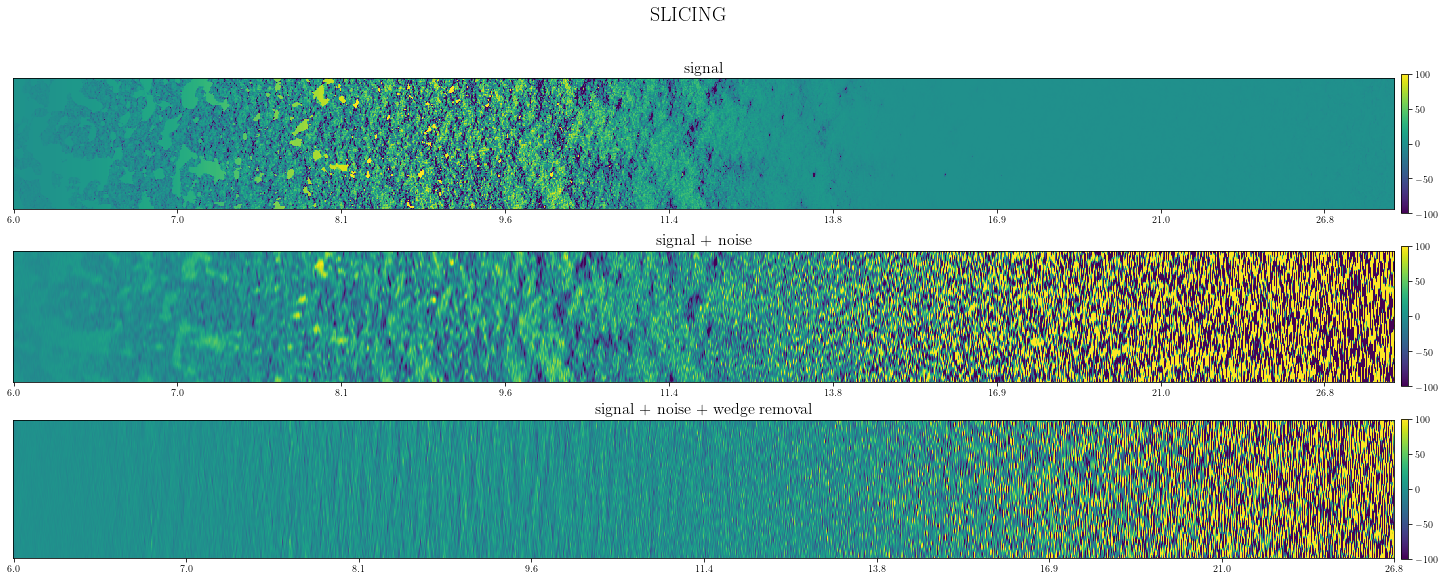

In [291]:
Box_final = manual_slicing(Box, chunk_length = 200, blackman = False)
plotting(Box, Box_final, box_n_noise, f"{inputs.saving_location}slicing_{inputs.WalkerID:04d}.pdf", "SLICING")


In [292]:
def manual_simple_sliding(Box, wedge_correction = 1):
    Box_final = cp.empty(Box.shape, dtype = np.float32)
#     Noise = noise(inputs.depth_mhz, seed_index = 0).astype(np.float32)
    Box_inv = cp.fft.fft2(Box, axes=(0, 1)) + Noise
    Box_inv[uv_bool] = 0
    Box_inv = cp.fft.fft(Box_inv, axis = -1)
    
    k = cp.fft.fftfreq(Box.shape[0], d=1.5)
    k_parallel = cp.fft.fftfreq(Box.shape[-1], d=1.5)
    k_cube = cp.meshgrid(k, k, k_parallel)
    W = k_cube[2] / cp.sqrt(k_cube[0]**2 + k_cube[1]**2)
    
    for i in range(Box.shape[-1]):
        t_W = W / (multiplicative_fact[i] / wedge_correction)
        w = cp.logical_or(t_W < -1., t_W > 1.)
        Box_final[..., i] = cp.real(cp.fft.ifftn(Box_inv * w))[..., i]
    return Box_final

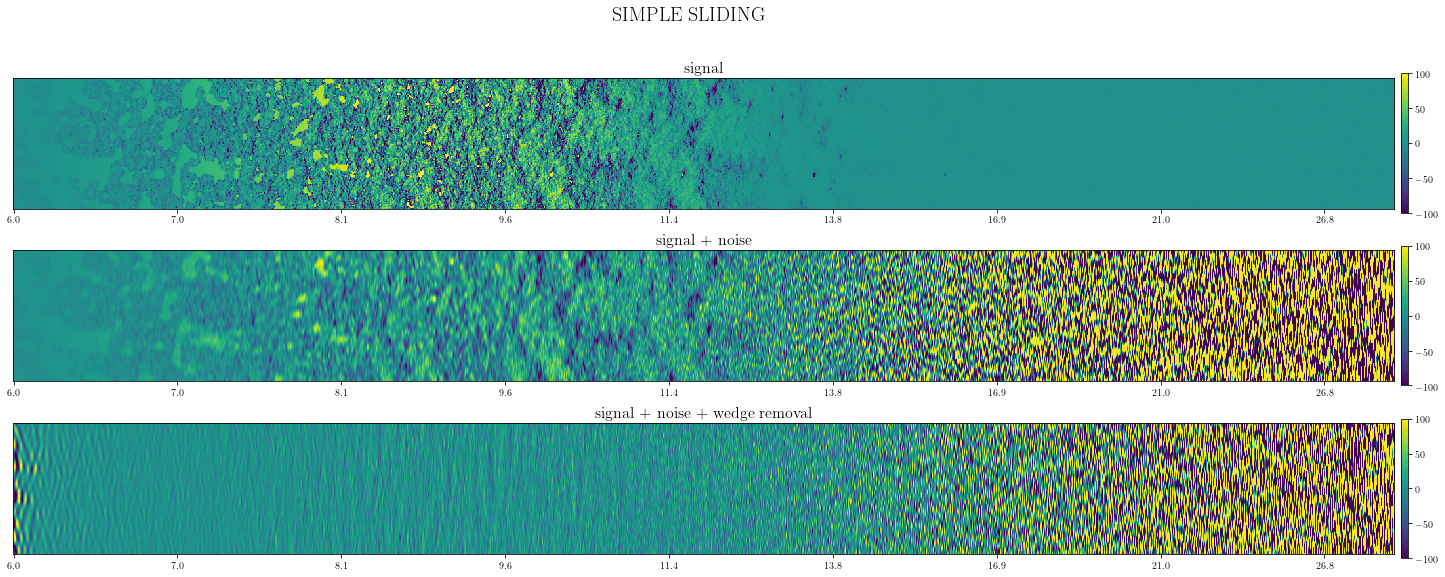

In [293]:
Box_final = manual_simple_sliding(Box)
plotting(Box, Box_final, box_n_noise, f"{inputs.saving_location}simple_sliding_{inputs.WalkerID:04d}.pdf", "SIMPLE SLIDING")

In [27]:
chunk_length = 501
k = cp.fft.fftfreq(200, d=1.5)
k_parallel = cp.fft.fftfreq(chunk_length, d=1.5)
delta_k = k_parallel[1] - k_parallel[0]
k_cube = cp.meshgrid(k, k, k_parallel)

bm = cp.abs(cp.fft.fft(cp.blackman(chunk_length)))**2
buffer = delta_k * (cp.where(bm / cp.amax(bm) <= 1e-10)[0][0] - 1)

BM = cp.blackman(chunk_length)[cp.newaxis, cp.newaxis, :]

In [46]:
def manual_sliding(Box, blackman = True, fwhm = None):
    if fwhm == None:
        correction = 1.
    else:
        correction = np.sin(fwhm * np.pi/180 / 2)
    
    Box_final = cp.empty(Box.shape, dtype = np.float32)
    Box_uv = cp.fft.fft2(Box, axes=(0, 1)) + Noise
    Box_uv[uv_bool] = 0
    
    t_box = cp.copy(Box_uv[..., :chunk_length])
    W = k_cube[2] / (cp.sqrt(k_cube[0]**2 + k_cube[1]**2) * (correction * multiplicative_fact[chunk_length - 1]) + buffer)
    w = cp.logical_or(W < -1., W > 1.)
    Box_final[..., :chunk_length // 2] = cp.real(cp.fft.ifftn(cp.fft.fft(t_box, axis = -1) * w))[..., :chunk_length // 2]
    
    t_box = cp.copy(Box_uv[..., -chunk_length:])
    W = k_cube[2] / (cp.sqrt(k_cube[0]**2 + k_cube[1]**2) * (correction * multiplicative_fact[-1]) + buffer)
    w = cp.logical_or(W < -1., W > 1.)
    Box_final[..., -chunk_length // 2 : ] = cp.real(cp.fft.ifftn(cp.fft.fft(t_box, axis = -1) * w))[..., -chunk_length // 2 :]
    
    for i in range(Box.shape[-1] - chunk_length + 1):
        t_box = cp.copy(Box_uv[..., i:i+chunk_length])
        W = k_cube[2] / (cp.sqrt(k_cube[0]**2 + k_cube[1]**2) * (correction * multiplicative_fact[i + chunk_length - 1]) + buffer)
        w = cp.logical_or(W < -1., W > 1.)
        if blackman == True:
            t_box *= BM
        Box_final[..., i + chunk_length // 2] = cp.real(cp.fft.ifftn(cp.fft.fft(t_box, axis = -1) * w))[..., chunk_length // 2]
        
    return Box_final.astype(np.float32)


def borders(current_position, box_length, max_chunk_length = None):
    buff = min(current_position, box_length - current_position - 1)
    if max_chunk_length != None:
        buff = min(max_chunk_length // 2, buff)
    return current_position - buff, current_position + buff + 1

def smart_manual_sliding(Box, min_chunk_length, max_chunk_length = None, blackman = True, fwhm = None):
    if fwhm == None:
        correction = 1.
    else:
        correction = np.sin(fwhm * np.pi/180 / 2)
    k = cp.fft.fftfreq(200, d=1.5)
    k_parallel = cp.fft.fftfreq(min_chunk_length, d=1.5)
    delta_k = k_parallel[1] - k_parallel[0]
    k_cube = cp.meshgrid(k, k, k_parallel)
    
    bm = cp.abs(cp.fft.fft(cp.blackman(min_chunk_length)))**2
    buffer = delta_k * (cp.where(bm / cp.amax(bm) <= 1e-10)[0][0] - 1)

    BM = cp.blackman(min_chunk_length)[cp.newaxis, cp.newaxis, :]
    
    Box_final = cp.empty(Box.shape, dtype = np.float32)
    Box_uv = cp.fft.fft2(Box, axes=(0, 1)) + Noise
    Box_uv[uv_bool] = 0
    
    t_box = cp.copy(Box_uv[..., :min_chunk_length])
    W = k_cube[2] / (cp.sqrt(k_cube[0]**2 + k_cube[1]**2) * (correction * multiplicative_fact[min_chunk_length - 1]) + buffer)
    w = cp.logical_or(W < -1., W > 1.)
    Box_final[..., :min_chunk_length // 2] = cp.real(cp.fft.ifftn(cp.fft.fft(t_box, axis = -1) * w))[..., :min_chunk_length // 2]
    
    t_box = cp.copy(Box_uv[..., -min_chunk_length:])
    W = k_cube[2] / (cp.sqrt(k_cube[0]**2 + k_cube[1]**2) * (correction * multiplicative_fact[-1]) + buffer)
    w = cp.logical_or(W < -1., W > 1.)
    Box_final[..., -min_chunk_length // 2 : ] = cp.real(cp.fft.ifftn(cp.fft.fft(t_box, axis = -1) * w))[..., -min_chunk_length // 2 :]
    
    for i in range(min_chunk_length // 2, Box.shape[-1] - min_chunk_length // 2):
        a, b = borders(i, Box.shape[-1], max_chunk_length)
#         print(i, a, b)
        k_parallel = cp.fft.fftfreq(b - a, d=1.5)
        delta_k = k_parallel[1] - k_parallel[0]
        k_cube = cp.meshgrid(k, k, k_parallel)
        bm = cp.abs(cp.fft.fft(cp.blackman(b - a)))**2
        buffer = delta_k * (cp.where(bm / cp.amax(bm) <= 1e-10)[0][0] - 1)
        BM = cp.blackman(b - a)[cp.newaxis, cp.newaxis, :]
        t_box = cp.copy(Box_uv[..., a:b])
#         print(t_box.shape, BM.shape, a, b)
        W = k_cube[2] / (cp.sqrt(k_cube[0]**2 + k_cube[1]**2) * (correction * multiplicative_fact[b - 1]) + buffer)
        w = cp.logical_or(W < -1., W > 1.)
        if blackman == True:
            t_box *= BM
        Box_final[..., i] = cp.real(cp.fft.ifftn(cp.fft.fft(t_box, axis = -1) * w))[..., (b - a) // 2]
        
    return Box_final.astype(np.float32)


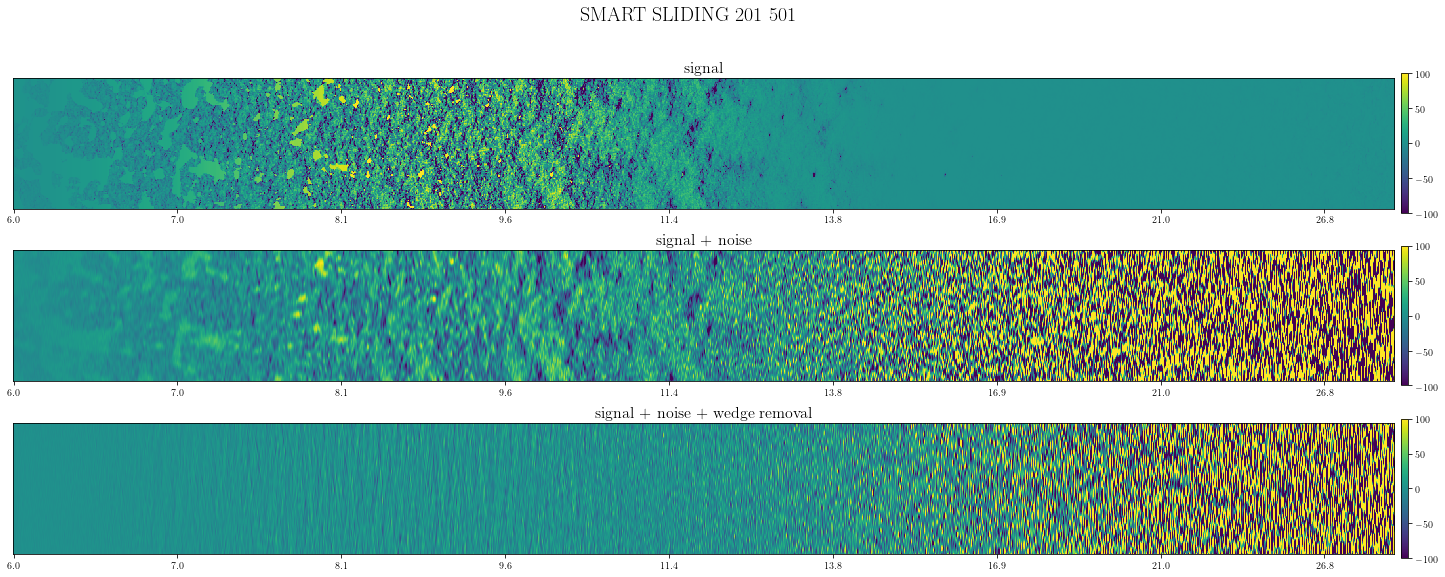

In [47]:
Box_final = smart_manual_sliding(Box, 201, 501, blackman=True)
plotting(Box, Box_final, box_n_noise, f"{inputs.saving_location}sliding_blackman_{inputs.WalkerID:04d}.pdf", "SMART SLIDING 201 501")

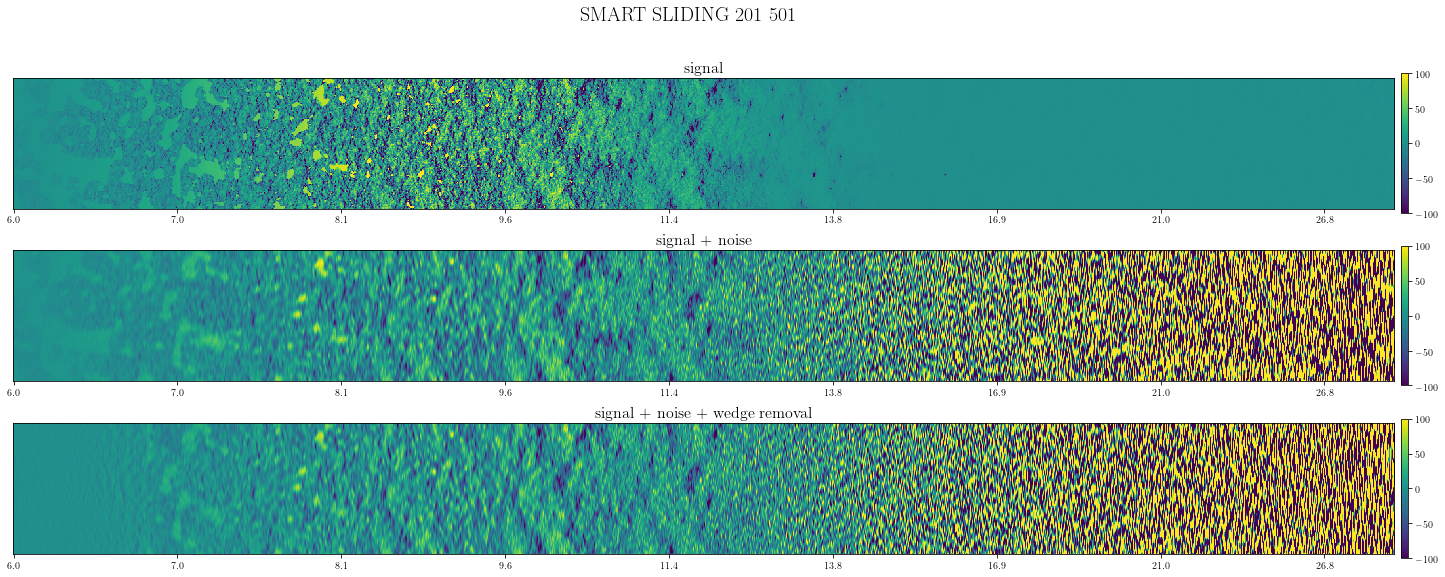

In [48]:
Box_final = smart_manual_sliding(Box, 201, 501, blackman=True, fwhm = 2.5)
plotting(Box, Box_final, box_n_noise, f"{inputs.saving_location}sliding_blackman_{inputs.WalkerID:04d}.pdf", "SMART SLIDING 201 501")

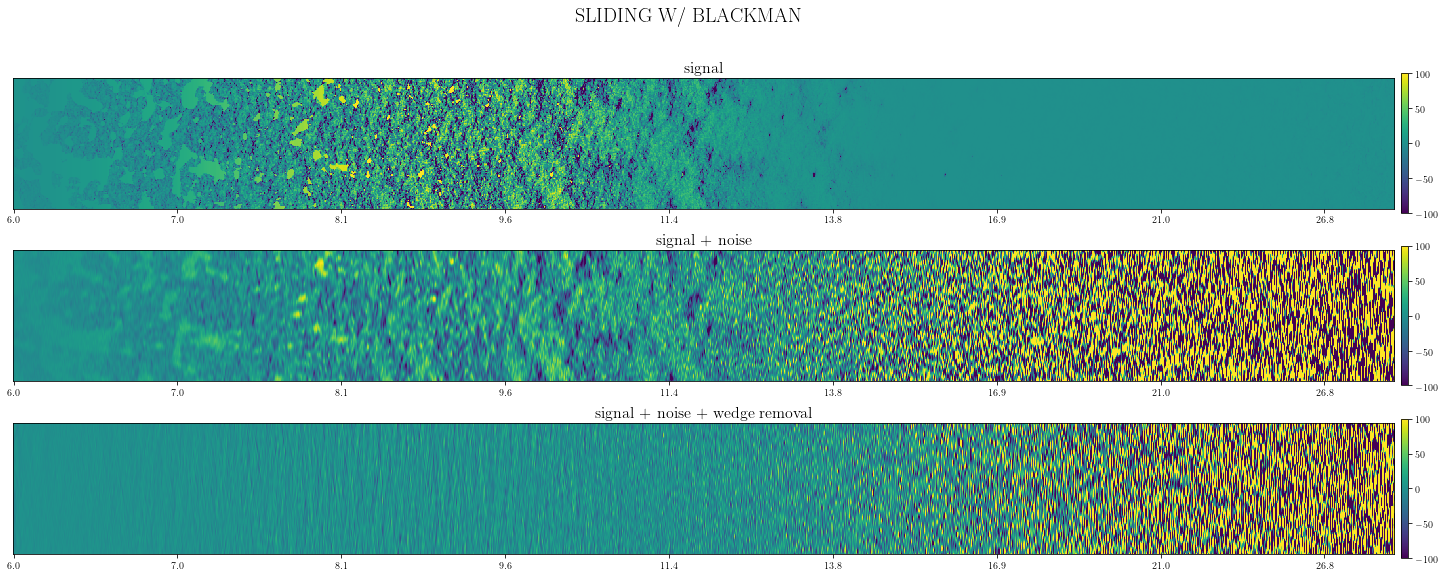

In [29]:
Box_final = manual_sliding(Box, blackman=True)
plotting(Box, Box_final, box_n_noise, f"{inputs.saving_location}sliding_blackman_{inputs.WalkerID:04d}.pdf", "SLIDING W/ BLACKMAN")

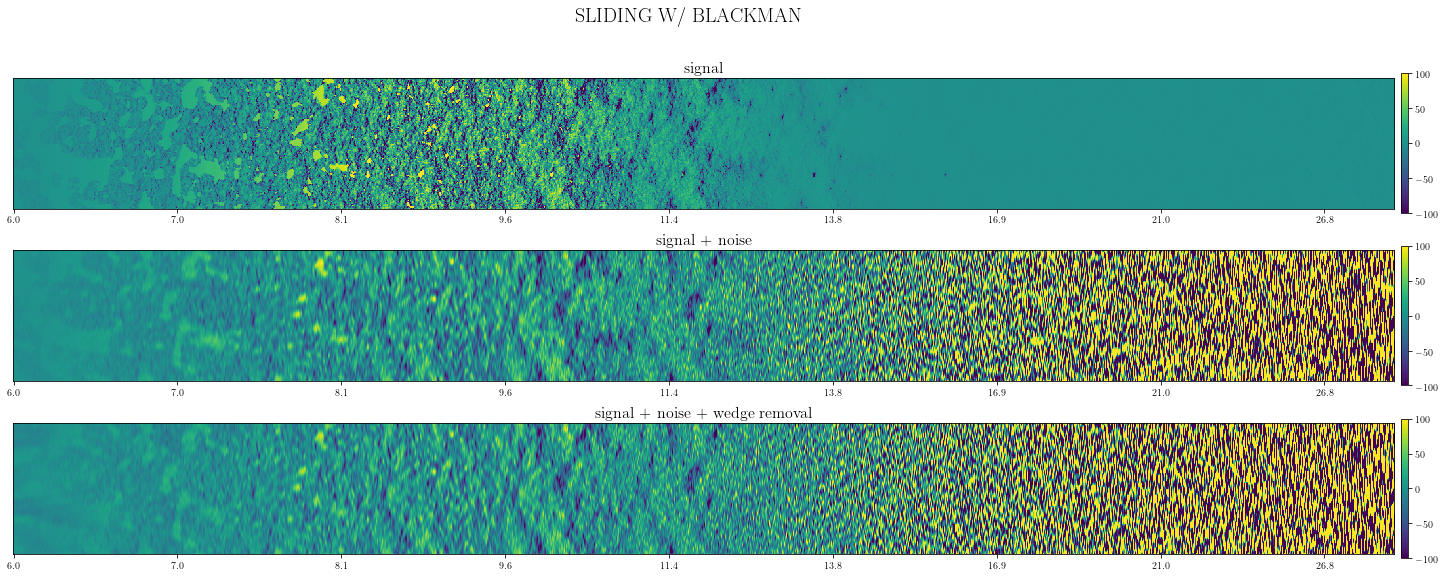

In [30]:
Box_final = manual_sliding(Box, blackman=True, fwhm = 2.5)
plotting(Box, Box_final, box_n_noise, f"{inputs.saving_location}sliding_blackman_{inputs.WalkerID:04d}.pdf", "SLIDING W/ BLACKMAN")

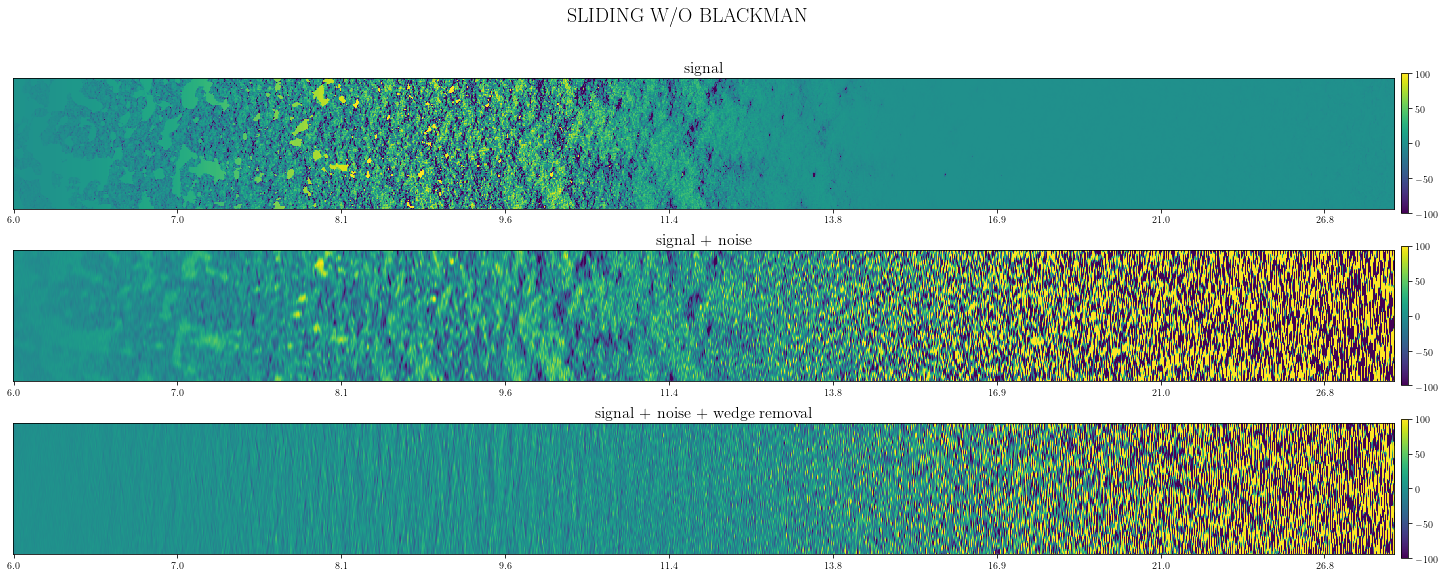

In [296]:
Box_final = manual_sliding(Box, blackman=False)
plotting(Box, Box_final, box_n_noise, f"{inputs.saving_location}sliding_{inputs.WalkerID:04d}.pdf", "SLIDING W/O BLACKMAN")

In [4]:
Box.shape

(200, 200, 2107)

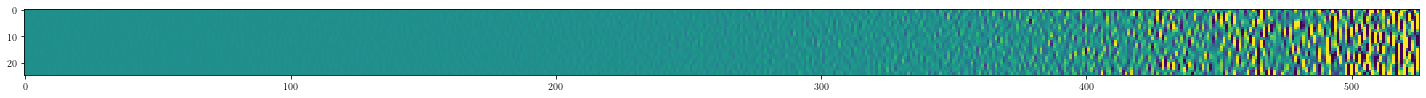

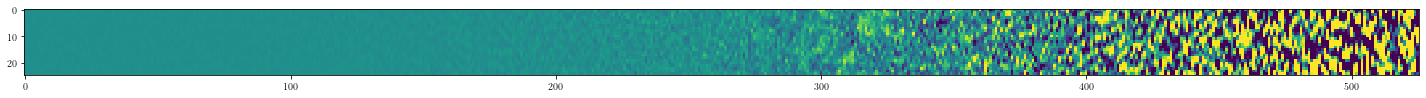

In [22]:
plt.figure(figsize=(25, 3))
plt.imshow(np.load("/scratch/d.prelogovic/data/SKA_1000_wedge/lightcone_depthMhz_0_walker_{:04d}_slice_{:d}_seed_{:d}.npy".format(8, 0, 0))[0], vmin = -1e2, vmax = 1e2)
plt.show()
plt.figure(figsize=(25, 3))
plt.imshow(np.load("/scratch/d.prelogovic/data/SKA_1000/lightcone_depthMhz_0_walker_{:04d}_slice_{:d}_seed_{:d}.npy".format(8, 0, 0))[0], vmin = -1e2, vmax = 1e2)
plt.show()

NotADirectoryError: [Errno 20] Not a directory: '/scratch/d.prelogovic/data/SKA_1000_wedge/lightcone_depthMhz_0_walker_0002_slice_2_seed_0.npy'